In [9]:
#import libraries
import matplotlib.pyplot as plt
import pandas as pd
import time
from IPython.display import clear_output
import csv

#from stable_baselines3.common.policy import MlpPolicy
from stable_baselines3.common.vec_env import DummyVecEnv
#from stable_baselines3.common import make_vec_env
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env

import warnings
warnings.filterwarnings('ignore')

In [1]:
#import the environment
import custom_environment_v22 as custom_environment
#make the environment
training_env = custom_environment.tenPTrainingEnv
training_env.reset(randomReset=True)
training_env.render()

CR: -35
CR: -35
Eval Num: 42
FULL EVAL
Number of limited first locations: 42
Number of limited second locations: 42
CR: -35
CR: -35
Eval Num: 182
FULL EVAL
Number of limited first locations: 182
Number of limited second locations: 182
CR: -25
CR: -35
Eval Num: 240
FULL EVAL
Number of limited first locations: 240
Number of limited second locations: 240
CR: -35
CR: -35
Eval Num: 650
FULL EVAL
Number of limited first locations: 650
Number of limited second locations: 650
CR: -35
CR: -35
Eval Num: 870
FULL EVAL
Number of limited first locations: 870
Number of limited second locations: 870
CR: -35
CR: -35
Eval Num: 1406
FULL EVAL
Number of limited first locations: 1406
Number of limited second locations: 1406
CR: -35
CR: -35
Eval Num: 1722
FULL EVAL
Number of limited first locations: 1722
Number of limited second locations: 1722
CR: -35
CR: -35
Eval Num: 2550
FULL EVAL
Number of limited first locations: 2550
Number of limited second locations: 2550
CR: -35
CR: -35
Eval Num: 3080
FULL EVAL
N

In [11]:
from stable_baselines3.common.callbacks import EvalCallback

# Separate evaluation env
eval_env = custom_environment.tenPEvalEnv
eval_env.reset(randomReset=False, scen=0)
eval_env.render()

best_model_save_name = './FULLdense_tenP_attempt1'
log_file = './FULLdense_tenP_attempt1_log_files'

eval_freq = 2000
n_eval_episodes = 42

# Use deterministic actions for evaluation
eval_callback = EvalCallback(eval_env, best_model_save_path=best_model_save_name,
                             log_path=log_file, eval_freq=eval_freq,
                             deterministic=True, render=False, verbose=0, n_eval_episodes=n_eval_episodes)
                             

[[2 1 0 0 4 4 4 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 9 0 0 8 0 0 0]] 

Drone at goal: False
Drone at goal: False


In [12]:
# Load the best model from previous training
previous_best_model_save_path = './ten_by_ten_base5/best_model.zip'
previous_best_model = PPO.load(previous_best_model_save_path)

# Create a new PPO model for further training
new_model = PPO("MlpPolicy", training_env, verbose=0, tensorboard_log='./ppo_tensorboard')

# Set the policy parameters of the new model to the ones from the best_model
new_model.policy.load_state_dict(previous_best_model.policy.state_dict())

training_env.reset()
eval_env.reset(scen=1)

# Continue training with the new model
new_model.learn(total_timesteps=1000000, callback=eval_callback)

fixed scenario: 1


In [13]:
#load the best new model
best_new_model_save_path = './FULLdense_tenP_attempt1/best_model.zip'
best_new_model = PPO.load(best_new_model_save_path)
best_new_model.set_env(eval_env, force_reset=True)

In [14]:
#open a csv file to write to to log results
with open('testing.csv', mode='w') as file:
    write = csv.writer(file)
    #initialize the number of total successful episodes
    total_successful_episodes = 0
    total_system_rewards = 0
    total_crash_count = 0
    scenario_number=1
    episodes_without_crashes = 0
    #run x episodes
    for episode in range(1000):
        #reset the environment and store the initial observation
        observations = eval_env.reset(randomReset=True, scen=0)
        #print(observations)
        #eval_env.render()
        #reset total episode rewards
        total_episode_rewards = 0
        #set done to false and then complete the code below while the episode is not done
        done = False
        while not done: 
            action, _ = best_new_model.predict(observations, deterministic=True)
            observations, rewards, termination, info = eval_env.step(action)
            #print(observations)
            #add the rewards to the total episode rewards
            total_episode_rewards += rewards
            #if all of the drones are terminated, set done to true
            if termination == True:
                done = True
            #render the environment (save for when running a small amount of episodes)
            #eval_env.render()
            #add a time sleep for when rendering the environment so it doesn't go too fast
            #time.sleep(.5)
            #clear the output when rendering so it flashes as the environment is updated
            #clear_output(wait=True)
            #print(total_episode_rewards)
        if info['reached_goals'] == True:
            total_successful_episodes += 1
        total_crash_count += info['crash_count']
        if info['crash_count'] == 0:
            episodes_without_crashes += 1
        total_system_rewards += total_episode_rewards
        #write the rewards to a csv file
        write.writerow([(episode+1), total_episode_rewards])
        scenario_number+=1
print("Total successful episodes: {}".format(total_successful_episodes))
print("average system rewards: {}".format(total_system_rewards/(episode+1)))
print('total crash count:', total_crash_count)
print('episodes without crashes:', episodes_without_crashes)

print('scenario_number:', scenario_number)

Total successful episodes: 1000
average system rewards: 177.437
total crash count: 0
episodes without crashes: 1000
scenario_number: 1001


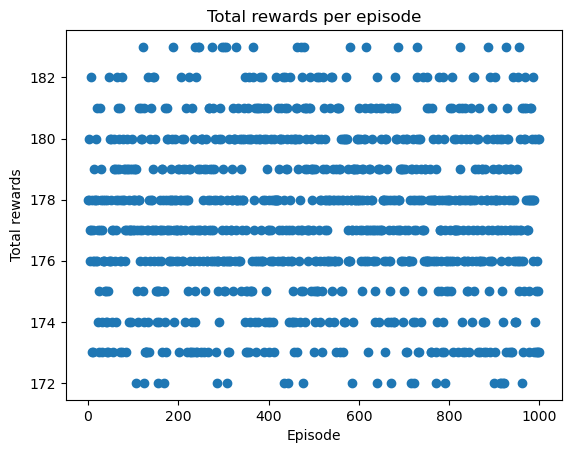

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Plot the rewards from the CSV file
df = pd.read_csv('testing.csv', header=None)

# Plot the first column as the x-axis and the second column as the y-axis
plt.scatter(df.iloc[:, 0], df.iloc[:, 1])
plt.xlabel('Episode')
plt.ylabel('Total rewards')
plt.title('Total rewards per episode')
plt.show()